# Classifying

This notebook tests a number of classification algorithms to determine if it is possible to classify census tracts into their respective clusters (representing gentrification status) using the census' current demographic state.

In [1]:
import pandas as pd
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import Classifier_helper_functions as helper
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [9]:
# import the csv that has the clusters assigned to each tract
df = pd.read_csv('CSV_files/clusters.csv',index_col=0)
df.head()

,tractid,cluster,HINC00_PC,MHMVAL00_PC,MRENT00_PC,percent_owneroccupied_00_PC,percent_non-white00_PC,percent_4yrcollege_degree_ormore_PC,cluster_name
0,25025000100,1,-5.21,56.78,50.11,-12.52,27.33,-24.91,Becoming more affordable
1,25025000201,1,-16.97,100.30,41.78,-6.08,22.63,12.61,Becoming more affordable
2,25025000202,1,-24.08,56.41,58.41,-7.61,2.15,11.10,Becoming more affordable
3,25025000301,2,25.76,91.09,51.29,4.77,45.58,37.54,Remaining costly
4,25025000302,1,-15.31,24.16,15.71,-3.60,32.15,-1.16,Becoming more affordable


In [10]:
# subset tracts and clusters
df1=df.iloc[:,0:2]

In [12]:
# import the data from the 2000 census 
df2 = pd.read_csv('CSV_files/Final_2000_data.csv',index_col=0)
df3 = pd.read_csv('CSV_files/Final_2000_data_sample.csv',index_col=0)

In [13]:
# join the dataframes
df = df1.merge(df2,how='inner',on='tractid')

df_final = df.merge(df3,how='inner',on='tractid')
df_final.set_index('tractid',inplace=True)

In [15]:
df.head()

,tractid,cluster,state,county,tract,POP00,percent_white00,percent_black00,percent_asian00,percent_hispanic00,percent_indian00,percent_chinese00,percent_filip00,percent_japan00,percent_korean00,percent_viet00,percent_mex00,percent_pr00,percent_cuban00,percent_vacant_housing00,percent_occupied_housing00,percent_under18_00,percent_60andup_00,percent_75andup_00,percent_owneroccupied_00,percent_renteroccupied_00,percent_non-white00
0,25025000100,1,MA,Suffolk County,Census Tract 1,3968.000000,70.816532,4.989919,10.937500,8.795363,1.008065,6.174395,0.302419,0.302419,0.378024,2.469758,0.579637,0.982863,0.151210,3.159851,96.840149,13.734879,13.785282,5.317540,27.323420,69.516729,37.626008
1,25025000201,1,MA,Suffolk County,Census Tract 2.01,3887.000000,77.617700,3.524569,8.978647,7.435040,0.848984,5.737072,0.668896,0.282995,0.360175,0.463082,0.643170,0.874711,0.643170,1.969504,98.030496,11.577052,10.959609,4.296373,29.415502,68.614994,30.743504
2,25025000202,1,MA,Suffolk County,Census Tract 2.02,3925.000000,64.280255,7.617834,15.439490,11.261146,1.146497,9.605096,0.101911,0.178344,0.560510,2.726115,0.484076,3.312102,0.382166,1.451187,98.548813,19.031847,13.910828,4.713376,33.707124,64.841689,53.070064
3,25025000301,2,MA,Suffolk County,Census Tract 3.01,2923.000000,80.841601,3.386931,8.039685,5.542251,0.650017,4.618543,0.205269,0.102634,0.855286,0.273691,0.615806,0.581594,0.205269,2.931323,97.068677,12.076634,18.268902,8.279165,37.269682,59.798995,25.145399
4,25025000302,1,MA,Suffolk County,Census Tract 3.02,2909.483505,81.004657,2.295409,12.907518,3.193613,1.031271,8.915503,0.399202,0.731870,1.131071,0.365935,0.133067,0.465735,0.066534,1.556709,98.443286,9.214904,15.435795,6.154358,48.628614,49.814677,31.936128


In [16]:
df_final['cluster'].value_counts()

2    82
1    77
0    31
Name: cluster, dtype: int64

In [ ]:
# lets drop classes 3 since it only has 1 tract
df_final = df_final[df_final['cluster']!=3]

In [ ]:
df_final.columns

In [ ]:
df_final['cluster'].value_counts()

In [17]:
# split into X and Y
X = df_final[['percent_white00', 'percent_black00',
       'percent_asian00', 'percent_hispanic00', 'percent_indian00',
       'percent_chinese00', 'percent_filip00', 'percent_japan00',
       'percent_korean00', 'percent_viet00', 'percent_mex00', 'percent_pr00',
       'percent_cuban00', 'percent_vacant_housing00',
       'percent_occupied_housing00', 'percent_under18_00',
       'percent_60andup_00', 'percent_75andup_00', 'percent_owneroccupied_00',
       'percent_renteroccupied_00', 'percent_non-white00', 'INCPC00', 'HINC00',
       'MHMVAL00', 'MRENT00', 'percent_foreign_born', 'percent_naturalized',
       'percent_recent_immigrants(10)', 'percent_other_languages',
       'percent_hs_degree_orless', 'percent_4yrcollege_degree_ormore',
       'percent_married', 'percent_unemployed', 'percent_employed',
       'percent_professional', 'percent_manufacturing',
       'percent_self_employed', 'percent_poverty', 'percent_houses_30yrsago',
       'percent_multiunit_houses']]
Y = df_final['cluster']
Y=Y.astype('str')

# Dummy Classifier

In [18]:
# train test split
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=.2)

In [19]:
# create instance of the class
dummy_clf = DummyClassifier('most_frequent')
dummy_clf.fit(X_train,y_train)
y_hat_train = dummy_clf.predict(X_train)
y_hat_test = dummy_clf.predict(X_test)

In [20]:
print(accuracy_score(y_hat_train,y_train))
print(accuracy_score(y_hat_test,y_test))

0.45394736842105265
0.34210526315789475


Confusion matrix, without normalization
[[ 0  0  6]
 [ 0  0 19]
 [ 0  0 13]]


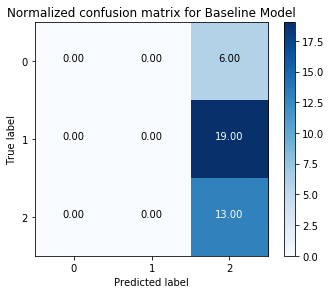

In [21]:
# confusion matrix
cnf_matrix = confusion_matrix(y_test, y_hat_test)
plt.figure(figsize=(5,4))

helper.plot_confusion_matrix(cnf_matrix, normalize=False,classes=[0,1,2],
                      title='Normalized confusion matrix for Baseline Model')

plt.savefig('Dummy_Confusion')
plt.show()

## KNN

In [22]:
knn = KNeighborsClassifier()
parameters={'n_neighbors':[10,12,13,14,15,16,17,18,19,20]}
clf = GridSearchCV(knn,parameters,cv=5)
clf.fit(X,Y)

/Users/Kristinabarounis/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [10, 12, 13, 14, 15, 16, 17, 18, 19, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [23]:
clf.best_params_

{'n_neighbors': 15}

In [24]:
knn = KNeighborsClassifier(n_neighbors=14)
helper.stratified_k_fold(knn,3,X,Y)

('Train scores from each iteration:[0.584, 0.52, 0.576]',
 'Average K-Fold train score: 0.56',
 'Test scores from each iteration:[0.4461538461538462, 0.4307692307692308, 0.47692307692307695]',
 'Average K-Fold test score: 0.4512820512820513')

## Decision Tree

In [25]:
dt = DecisionTreeClassifier()
parameters={'criterion':['gini','entropy'],
            'max_depth':[5,10,15],
            'min_samples_split':[2,3,4,5,6,7],
            'min_samples_leaf':[1,2,3,4,5,6,7],
            'max_features':[1,2,3,4,5,6,7]   
}
clf_2 = GridSearchCV(dt,parameters,cv=5)
clf_2.fit(X,Y)

/Users/Kristinabarounis/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [5, 10, 15], 'min_samples_split': [2, 3, 4, 5, 6, 7], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7], 'max_features': [1, 2, 3, 4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [26]:
clf_2.best_params_

{'criterion': 'gini',
 'max_depth': 15,
 'max_features': 1,
 'min_samples_leaf': 3,
 'min_samples_split': 5}

In [27]:
dt= DecisionTreeClassifier(criterion='entropy',max_depth=5,max_features=4,min_samples_leaf=5,min_samples_split=6)

helper.stratified_k_fold(dt,5,X,Y)

('Train scores from each iteration:[0.7066666666666667, 0.6933333333333334, 0.7333333333333333, 0.7066666666666667, 0.6666666666666666]',
 'Average K-Fold train score: 0.7013333333333333',
 'Test scores from each iteration:[0.35, 0.3, 0.6, 0.5, 0.45]',
 'Average K-Fold test score: 0.44000000000000006')

## Random Forest

In [28]:
rf = RandomForestClassifier()
parameters={'criterion':['gini','entropy'],
            'max_depth':[10,15,20],
            'min_samples_split':[2,3,4,5,6,7],
            'min_samples_leaf':[1,2,3,4,5,6,7],
            'max_features':[1,2,3,4,5,6,7]
    }
clf_3 = GridSearchCV(dt,parameters,cv=5,n_jobs=-1)
clf_3.fit(X,Y)

/Users/Kristinabarounis/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=6, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [10, 15, 20], 'min_samples_split': [2, 3, 4, 5, 6, 7], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7], 'max_features': [1, 2, 3, 4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [29]:
clf_3.best_params_

{'criterion': 'gini',
 'max_depth': 20,
 'max_features': 6,
 'min_samples_leaf': 7,
 'min_samples_split': 7}

In [30]:
rt = RandomForestClassifier(criterion='gini',max_depth=10,max_features=2,min_samples_leaf=6,min_samples_split=7)
helper.stratified_k_fold(rt,5,X,Y)

/Users/Kristinabarounis/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


('Train scores from each iteration:[0.78, 0.7866666666666666, 0.8333333333333334, 0.76, 0.7333333333333333]',
 'Average K-Fold train score: 0.7786666666666667',
 'Test scores from each iteration:[0.4, 0.575, 0.5, 0.575, 0.575]',
 'Average K-Fold test score: 0.525')

## XGBoost

In [31]:
clf = XGBClassifier()
clf.fit(X_train, y_train)
training_preds = clf.predict(X_train)
val_preds = clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))


Training Accuracy: 100.0%
Validation accuracy: 57.89%


In [32]:
param_grid = {
    "learning_rate": [0.1,0.2,0.3,0.4],
    'max_depth': [2,3,4,5,6],
    'min_child_weight': [10,12,13,14,15],
    'subsample': [0.7],
    'n_estimators': [5, 30, 100, 250],
}

In [ ]:
grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=5, n_jobs=1)
grid_clf.fit(X, Y)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
val_preds = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

In [ ]:
# confusion matrix
cnf_matrix = confusion_matrix(y_test, val_preds)
plt.figure(figsize=(5,4))

helper.plot_confusion_matrix(cnf_matrix, normalize=False,classes=[0,1,2],
                      title='Normalized confusion matrix for Baseline Model')

plt.savefig('Dummy_Confusion')
plt.show()

In [ ]:
xgb = XGBClassifier(learning_rate=0.3,max_depth=2,min_child_weight=12,n_estimators=5,subsample=0.7)
helper.stratified_k_fold(xgb,7,X,Y)

## Predict using 2010 data!!!!!!

In [ ]:
# import the data from the 2000 census 
df2 = pd.read_csv('CSV_files/Final_2010_data.csv',index_col=0)
df3 = pd.read_csv('CSV_files/Final_2010_data_sample.csv',index_col=0)

In [ ]:
# join the dataframes
df = df3.merge(df2,how='inner',on='tractid')